In [1]:
import pandas as pd
df = pd.read_csv('data/data.csv')
# df = df.sample(frac=0.001, random_state=42)
df = df.sample(n=2000, random_state=42)
print(df.info())
print(df[df['content'].isnull()])

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 16128 to 22944
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1999 non-null   object
 1   label    2000 non-null   object
 2   start    2000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 62.5+ KB
None
     content label  start
8194     NaN   NEG      1


In [2]:
df = df.dropna(subset=['content'])
df = df.reset_index(drop=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1999 non-null   object
 1   label    1999 non-null   object
 2   start    1999 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.0+ KB
None


In [3]:
from underthesea import word_tokenize
df["content_segmented"] = df["content"].apply(lambda x: word_tokenize(x, format="text"))
print(df.head())

/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                             content label  start  \
0                                    Máy chụp rất ok   POS      5   
1  Chất lượng sản phẩm tuyệt vời Đóng gói sản phẩ...   POS      5   
2                                Chất lượng tam duoc   NEG      2   
3                        Hang rât tôt ủng hộ dài dài   POS      5   
4                                   Vải cũng đẹp nữa   POS      5   

                                   content_segmented  
0                                    Máy chụp rất ok  
1  Chất_lượng sản_phẩm tuyệt_vời Đóng_gói sản_phẩ...  
2                                Chất_lượng tam_duoc  
3                        Hang rât tôt ủng_hộ dài dài  
4                                   Vải cũng đẹp nữa  


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

x_train = train_df["content"].tolist()
x_test = test_df["content"].tolist()

x_train_segmented = train_df["content_segmented"].tolist()
x_test_segmented = test_df["content_segmented"].tolist()

y_train = train_df["label"].tolist()
y_test = test_df["label"].tolist()



In [ ]:
from sklearn.naive_bayes import MultinomialNB

tmp = TfidfVectorizer(ngram_range=(1,2))
preproc   = tmp.build_preprocessor() 
tokenizer = tmp.build_tokenizer()   

vec = TfidfVectorizer(
    preprocessor=preproc,
    tokenizer=tokenizer,
    token_pattern=None,
    ngram_range=(1,2),
    min_df=2
)

pipe = Pipeline([
    ('tfidf', vec),
    ('nb',   MultinomialNB())
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha':          [0.1, 0.5, 1.0],
    'nb__fit_prior':      [True, False]
}

gs = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)

gs.fit(x_train_segmented, y_train)
print("Best hyper-parameters:", gs.best_params_)

y_pred_nb = gs.predict(x_test_segmented)
print("=== Naive Bayes ===")
print(classification_report(y_test, y_pred_nb))

Best hyper-parameters: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tfidf__ngram_range': (1, 2)}
=== Naive Bayes ===
              precision    recall  f1-score   support

         NEG       0.65      0.62      0.63        86
         NEU       0.30      0.10      0.15        61
         POS       0.77      0.90      0.83       253

    accuracy                           0.72       400
   macro avg       0.57      0.54      0.54       400
weighted avg       0.67      0.72      0.68       400



In [6]:
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
)

pipe_svm = Pipeline([
    ("tfidf", tfidf),
    ("svm",   LinearSVC(max_iter=10000))
])

param_grid_svm = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "svm__C":            [0.1, 1, 10],
    "svm__class_weight": [None, "balanced"]
}

gs_svm = GridSearchCV(
    pipe_svm,
    param_grid_svm,
    cv=3,
    n_jobs=-1,
    verbose=1
)

gs_svm.fit(x_train_segmented, y_train)

print("Best hyper-parameters (SVM):", gs_svm.best_params_)

y_pred_svm = gs_svm.predict(x_test_segmented)
print(classification_report(y_test, y_pred_svm))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best hyper-parameters (SVM): {'svm__C': 0.1, 'svm__class_weight': None, 'tfidf__ngram_range': (1, 1)}
              precision    recall  f1-score   support

         NEG       0.64      0.51      0.57        86
         NEU       0.27      0.07      0.11        61
         POS       0.74      0.92      0.82       253

    accuracy                           0.70       400
   macro avg       0.55      0.50      0.50       400
weighted avg       0.65      0.70      0.66       400



In [7]:
import os
from datasets import Dataset
from transformers import AutoTokenizer
import py_vncorenlp
import evaluate

label2id = {"NEG": 0, "NEU": 1, "POS": 2}
train_labels = [label2id[label] for label in y_train]
test_labels  = [label2id[label] for label in y_test]

save_directory = os.path.join(os.getcwd(), 'vncorenlp') 
py_vncorenlp.download_model(save_dir=save_directory)
rdrsegmenter = py_vncorenlp.VnCoreNLP(save_dir=save_directory)

def word_segment(sent):
    return ' '.join(rdrsegmenter.word_segment(sent))

x_train_seg = [word_segment(s) for s in x_train]
x_test_seg  = [word_segment(s) for s in x_test]

train_ds = Dataset.from_dict({"text": x_train_seg, "label": train_labels})
test_ds  = Dataset.from_dict({"text": x_test_seg,  "label": test_labels})

MODEL_v2 = "vinai/phobert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_v2)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn,  batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch",  columns=cols)


VnCoreNLP model folder /Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/vncorenlp already exists! Please load VnCoreNLP from this folder!
2025-06-28 10:34:39 INFO  WordSegmenter:24 - Loading Word Segmentation model
2025-06-28 10:34:39 INFO  PosTagger:23 - Loading POS Tagging model
2025-06-28 10:34:43 INFO  NerRecognizer:34 - Loading NER model
2025-06-28 10:34:49 INFO  DependencyParser:32 - Loading Dependency Parsing model


Map: 100%|██████████| 400/400 [00:00<00:00, 10646.18 examples/s]


In [8]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(MODEL_v2, num_labels=3)

accuracy  = evaluate.load("accuracy")
f1        = evaluate.load("f1")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro":  f1.compute(predictions=preds, references=labels, average="macro")["f1"],
        "precision": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall":    recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    }

training_args = TrainingArguments(
    output_dir="./phobert_sentiment",
    num_train_epochs=2,
    per_device_train_batch_size=4,      
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_steps=5000,
    save_total_limit=1,
    do_train=True,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print(metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
200,0.743100
400,0.639400
600,0.537500
800,0.544100


/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6396544575691223, 'eval_accuracy': 0.7975, 'eval_f1_macro': 0.6820565509090099, 'eval_precision': 0.7018601746537128, 'eval_recall': 0.6797617809817581, 'eval_runtime': 5.3141, 'eval_samples_per_second': 75.271, 'eval_steps_per_second': 9.409, 'epoch': 2.0}


/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_69439/3406889273.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


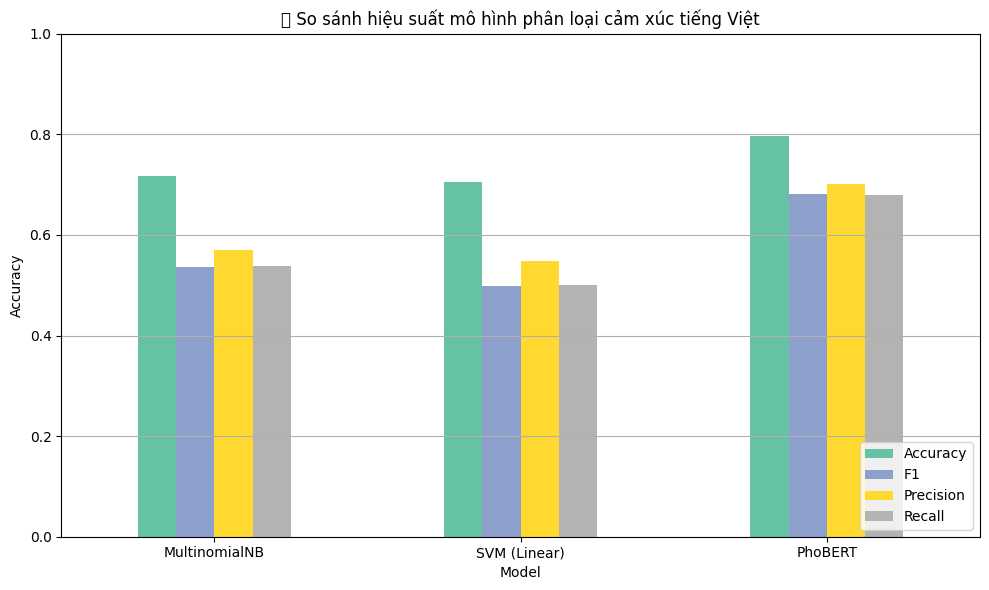

/var/folders/fq/vqgssw4s6ns5szvbhy3dfcgr0000gn/T/ipykernel_69439/3406889273.py:71: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tuankietnguyen/Documents/Learn/ThS/DataMining/Topic/uts-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


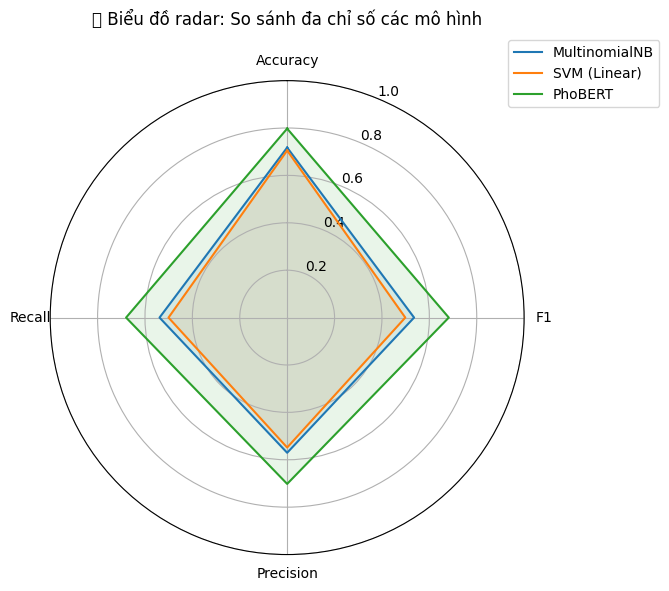

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

nb_metrics = {
    'Model': 'MultinomialNB',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1': f1_score(y_test, y_pred_nb, average='macro'),
    'Precision': precision_score(y_test, y_pred_nb, average='macro'),
    'Recall': recall_score(y_test, y_pred_nb, average='macro'),
}

svm_metrics = {
    'Model': 'SVM (Linear)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1': f1_score(y_test, y_pred_svm, average='macro'),
    'Precision': precision_score(y_test, y_pred_svm, average='macro'),
    'Recall': recall_score(y_test, y_pred_svm, average='macro'),
}

phobert_metrics = {
    "Model": "PhoBERT",
    "Accuracy": metrics["eval_accuracy"],
    "F1":       metrics["eval_f1_macro"],
    "Precision": metrics["eval_precision"],
    "Recall":    metrics["eval_recall"]
}

df = pd.DataFrame([nb_metrics, svm_metrics, phobert_metrics])
df.set_index("Model", inplace=True)
df = df.dropna(axis=1)  

df.plot(kind="bar", figsize=(10, 6), colormap="Set2", rot=0)
plt.title("📊 So sánh hiệu suất mô hình phân loại cảm xúc tiếng Việt")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis="y")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

labels = df.columns
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for model_name, row in df.iterrows():
    values = row.tolist()
    values += values[:1] 
    ax.plot(angles, values, label=model_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1.0)

plt.title("🌐 Biểu đồ radar: So sánh đa chỉ số các mô hình", y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
import torch
from transformers import AutoTokenizer

id2label = {0: "NEG", 1: "NEU", 2: "POS"}
label2id = {v: k for k, v in id2label.items()}

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

def word_segment(raw_text):
    return raw_text  

def predict_sentiment(texts):
    inputs = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    )
    inputs = {k: v.to(trainer.model.device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = trainer.model(**inputs).logits
        preds_pho = torch.argmax(logits, dim=-1).cpu().numpy()
    labels_pho = [id2label[int(i)] for i in preds_pho]

    seg_texts = [word_segment(t) for t in texts]
    labels_svm = list(gs_svm.best_estimator_.predict(seg_texts))
    labels_nb  = list(gs.best_estimator_.predict(seg_texts))

    return {
        "phobert": labels_pho,
        "svm":     labels_svm,
        "nb":      labels_nb
    }

if __name__ == "__main__":
    sample_texts = [
        "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!",   # POS
        "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn.",      # NEU
        "Chất lượng chán",                                    # NEG
        "Chất lượng tệ"                                    # NEG
    ]
    results = predict_sentiment(sample_texts)
    for model_name, preds in results.items():
        print(f"\n>>> {model_name.upper()}")
        for s, p in zip(sample_texts, preds):
            print(f"• \"{s}\"  →  {p}")



>>> PHOBERT
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEU
• "Chất lượng chán"  →  NEG
• "Chất lượng tệ"  →  NEG

>>> SVM
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEU
• "Chất lượng chán"  →  POS
• "Chất lượng tệ"  →  POS

>>> NB
• "Sản phẩm quá tuyệt vời, giao hàng siêu nhanh!"  →  POS
• "Hộp hơi móp, nhưng nhìn chung cũng tạm ổn."  →  NEU
• "Chất lượng chán"  →  POS
• "Chất lượng tệ"  →  POS
